# This notebook is an example of display of RDI ADCP data

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from pyproj import Geod
g = Geod(ellps='WGS84')

#import util_adcp
import cswot_adcp.adcp as ad
import cswot_adcp.maps as mp

---
## Load RDI ADCP file (STA: Short Time Averaged)

In [2]:
file_name = "ADCP_DriX__20220922T202647_018_000000.STA"

In [3]:
# read data

# STA file reading
STA=ad.read_WH300(file_name)
# navigation compensation
STA=ad.ADCPcompNav(STA)
" / ".join(list(STA))

'vel / amp / corr / prcnt_gd / Ens / pitch / roll / heading / Tsd_depth / c_sound / salinity / temp / route / vessel_speed / Ens_gps / vel comp Nav'

---
## DISPLAY data

### Display current velocity magnitude, direction and correlation

Text(0.5, 1.0, 'correlation')

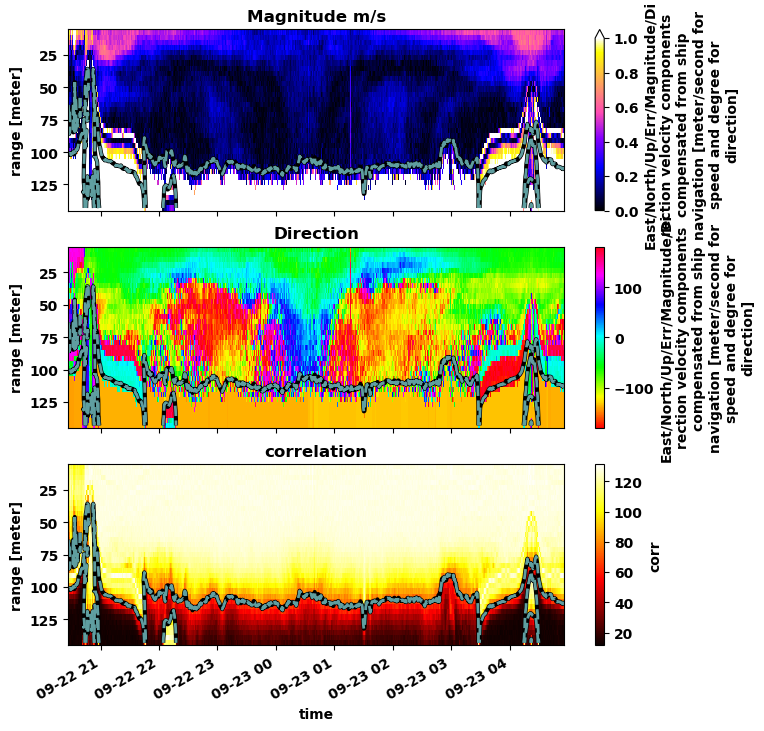

In [4]:
def add_corr_reference(STA, ax):
    level=70
    mean_corr = STA["corr"].mean("beam")
    mean_corr.plot.contour(ax=ax, levels=[70], colors="k", linewidths=3)
    mean_corr.plot.contour(ax=ax, levels=[70], colors="cadetblue", linestyles="--", linewidths=2)
    

fig, axes = plt.subplots(3,1, figsize=[8,8], sharex=True)

ax = axes[0]
p=STA["vel comp Nav"].sel(dir='Mag').plot(ax=ax, vmin=0,vmax=1,cmap='gnuplot2')
add_corr_reference(STA, ax)
p.axes.invert_yaxis()
ax.set_title('Magnitude m/s')
ax.set_xlabel("")

ax = axes[1]
p=STA["vel comp Nav"].sel(dir='Dir').plot(ax=ax, vmin=-180,vmax=180, cmap='hsv')
add_corr_reference(STA, ax)
p.axes.invert_yaxis()
ax.set_title('Direction')
ax.set_xlabel("")

ax = axes[2]
p=STA["corr"].mean("beam").plot(ax=ax, cmap='hot')
add_corr_reference(STA, ax)
p.axes.invert_yaxis()
ax.set_title('correlation')

### Current Arrow display

In [5]:
depth_arrows_m=10 #m (range of ADCP layer chosen for plotting current arrows)

In [6]:
# utils will be moved to library eventually

def get_extent(STA, buffer=.1):
    """ compute horizontal extent of the STA"""
    lon, lat = STA["elongitude_gps"], STA["elatitude_gps"]
    lon_scale = 1/np.cos(np.pi/180*lat.mean())
    extent = [lon.min() - buffer*lon_scale,
              lon.max() + buffer*lon_scale,
              lat.min() - buffer,
              lat.max() + buffer,
             ]
    extent = [float(e) for e in extent]
    return extent

def plot_sticks(STA, depth_arrows_m, ax=None, di=None, scale=3, width=1e-2, uref=1):
    """ plot STA currents at one depth
    
    Parameters:
    ----------
    STA: xr.Dataset
        adcp sta dataset
    depth_arrows_m: float
        selected plot depth
    di: int
        temporal subsampling
    scale, width: float
        quiver parameters, see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html
    uref: float
        velocity reference in m/s
    
    """
    
    _ds = (xr.merge([STA["vel comp Nav"].sel(dir="E").rename("u"), 
                     STA["vel comp Nav"].sel(dir="N").rename("v"), 
                   ],
                   compat='override',
                  )
           .assign_coords(longitude=STA["elongitude_gps"].interp(time_gps=STA.time),
                          latitude=STA["elatitude_gps"].interp(time_gps=STA.time),
                         )
           .sel(range=depth_arrows_m, method="nearest")
          )

    if ax is None:
        fig, ax, _ = mp.plot_map(extent=get_extent(STA, buffer=.01), 
                                 figsize=(10,10),
                                )

    if di is not None:
        _ds = _ds.isel(time=slice(0,None,di))

    ax.plot(_ds.longitude, _ds.latitude, color="b", transform=mp.crs)

    q = _ds.plot.quiver(x="longitude", y="latitude", u="u", v="v", 
                        scale=3, transform=mp.crs, zorder=-2, pivot="tail",
                        width=1e-2,
                       )
    qk = ax.quiverkey(q, 0.1, 0.9, uref, f'{uref} m/s', transform=mp.crs, color="cadetblue", labelcolor="cadetblue",
                      labelpos='W', coordinates='axes', zorder=10)
    return ax

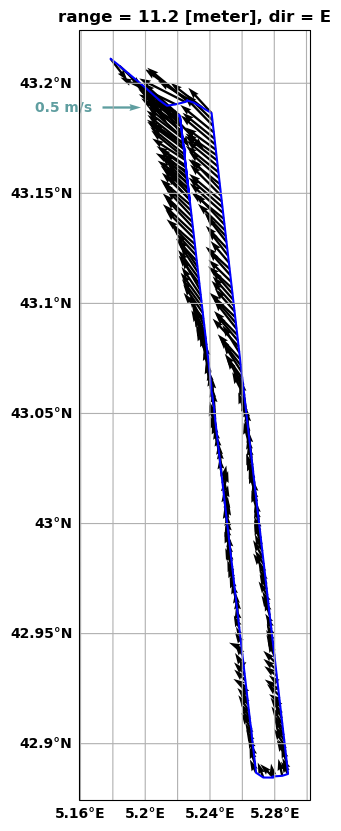

In [8]:
plot_sticks(STA, depth_arrows_m, di=4, scale=3, width=1e-2, uref=.5);